In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pydicom
import cv2
import pandas as pd
import numpy as np
from glob import glob
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import sys

from tqdm import tqdm
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")
torch.cuda.empty_cache()

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
TEST_ROOT = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
TEST_SERIES = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv'
TRAIN_ROOT = "./train_images"
TRAIN_ROOT = f"G:/rsna-abdominal-2023/reduced_512_tickness_5/"
TRAIN_ROOT = f"G:/rsna-2023-abdominal-trauma-detection/cropped_images_3ch/"
VOLUME = (128, 64, 64)

BATCH_SIZE = 32

VOLUME = (128, 128, 128)

VOLUME = (128, 224, 224)
VOLUME = (128, 256, 256)
WINDOW_STEP = 2
# Odd Number Only
WINDOW_WIDTH = 3
PAD_ENDING = True

SLICE_NUM = (128-1)//2 + 1

TARGET_COLS  = [
    "bowel_healthy","bowel_injury","extravasation_healthy", "extravasation_injury",
    "kidney_healthy", "kidney_low", "kidney_high",
    "liver_healthy", "liver_low", "liver_high",
    "spleen_healthy", "spleen_low", "spleen_high",
]
# TARGET_COLS  = [
#     "bowel_injury", "extravasation_injury",
#     "kidney_healthy", "kidney_low", "kidney_high",
#     "liver_healthy", "liver_low", "liver_high",
#     "spleen_healthy", "spleen_low", "spleen_high",
# ]
# organ_name = "eleven"
# organ_name = "bowel"
# TARGET_COLS  = [
#     "bowel_healthy","bowel_injury","extravasation_healthy", "extravasation_injury"]

TARGET_COLS  = ["liver_healthy","liver_low","liver_high"]
organ_name = "liver"
version="1007_seg"
version="1008"
# organ_name = "all"
seg_cls = ["1"]
# folder = "_3ch"

# TARGET_COLS  = ["kidney_healthy","kidney_low","kidney_high"]
# organ_name = "lkidney"
# version=1005
# seg_cls = ["1"]
# folder = "_3ch"

# TARGET_COLS  = ["spleen_healthy","spleen_low","spleen_high"]
# organ_name = "spleen"
version=1008
# seg_cls = ["2"]
# folder = "_3ch"
print(seg_cls, organ_name, TARGET_COLS,version)

['1'] liver ['liver_healthy', 'liver_low', 'liver_high'] 1008


In [5]:
SLICE_NUM

64

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        resnet = torchvision.models.resnet18()
        resnet.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        self.ltsm = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        # self.fc = nn.Linear(in_features=128*SLICE_NUM, out_features=len(TARGET_COLS))
        self.fc = nn.Linear(in_features=128*VOLUME[0], out_features=len(TARGET_COLS))
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        # x = x.view(batch_size * SLICE_NUM, WINDOW_WIDTH, VOLUME[1], VOLUME[2])
        x = x.view(batch_size * VOLUME[0], 2, VOLUME[1], VOLUME[2])
        x = self.backbone(x)
        # x = x.view(batch_size, SLICE_NUM, -1) 
        x = x.view(batch_size, VOLUME[0], -1) 
        
        x, _ = self.ltsm(x)
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        
        return x

In [7]:
model = Net().to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)
# model.load_state_dict(torch.load('/kaggle/input/rsna-2-5d-resnet-ltsm/model.pt')['model'])
# model.eval()
model = model.train()

In [8]:
train_df = pd.read_csv("./train.csv")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in glob("./train_images/*/*")}
s_ids = s_id_p_id.keys()

p_ids = [int(s_id_p_id[x]) for x in s_ids]
p_s_df = pd.DataFrame({"series_id":s_ids,"patient_id":p_ids})
train_df = p_s_df.merge(train_df,on="patient_id",how="left")


In [9]:
if organ_name!= "all" and organ_name!="eleven":
    print("before", len(train_df))
    processed_sid = []
    seg_files = []
    for seg_cl in seg_cls:
        seg_files += glob(f"./cropped_organs/*_{seg_cl}_*.jpeg")
    processed_sid = [x.split("_")[-3] for x in seg_files]
    processed_sid = np.unique(processed_sid)
    # processed_pid = np.unique([x.split("_")[-4].split("\\")[-1] for x in glob(f"./cropped_organs/*.jpeg")])
    # print("processed ", len(processed_pid),len(processed_sid))
    train_df = train_df[train_df.series_id.isin(processed_sid)]
    train_df = train_df.reset_index(drop=True)
    print("after", len(train_df))


before 4711
after 4647


In [28]:
len(train_df.patient_id.unique())
len(np.unique([int(x.split("\\")[-2]) for x in glob(f"./cropped_organs_sid/*/*")]))

3122

In [ ]:
import shutil
for folder in tqdm(glob(f"./cropped_organs_sid/*/*")):
    if len(os.listdir(folder))==0:
        print("removing", folder)
        shutil.rmtree(folder)
    # else:print("has data")
for folder in glob(f"./cropped_organs_sid/*"):
    if len(os.listdir(folder))==0:
        print("removing", folder)
        shutil.rmtree(folder)

In [11]:
copied_sids = [str(x.split("\\")[-1]) for x in glob(f"./cropped_organs_sid/*/*")]
train_df = train_df[train_df.series_id.isin(copied_sids)].reset_index(drop=True)
print("before", len(train_df))
# copy_df = train_df[~train_df.series_id.isin(copied_sids)]
# copy_df = copy_df.reset_index(drop=True)
# print("after", len(copy_df))

# sids = copy_df.series_id.values
# cls_counts =[[],[],[],[],[]]
# import shutil
# for c_sid in tqdm(sids):
#     c_pid = s_id_p_id[c_sid]
#     # print(c_pid,c_sid)
#     if not os.path.exists(f"./cropped_organs_sid/{c_pid}"):
#         os.mkdir(f"./cropped_organs_sid/{c_pid}")
#     if not os.path.exists(f"./cropped_organs_sid/{c_pid}/{c_sid}"):
#         os.mkdir(f"./cropped_organs_sid/{c_pid}/{c_sid}")
#     series_files = glob(f"./cropped_organs/{c_pid}_{c_sid}_*_*.jpeg")
#     for series_file in series_files:
#         shutil.copy(series_file,f"./cropped_organs_sid/{c_pid}/{c_sid}")
#     for cls_id in range(5):
#         cls_counts[cls_id].append(len(glob(f"./cropped_organs_sid/{c_pid}/{c_sid}/*_{cls_id+1}_*.jpeg")))


before 4647


In [12]:
def dicom_to_image(dcm):
    
    pixel_array = dcm.pixel_array
    
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        
    if dcm.PhotometricInterpretation == "MONOCHROME1":
        pixel_array = 1 - pixel_array
        
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope
    pixel_array = pixel_array * slope + intercept
    
    window_center = 50
    window_width = 400
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    pixel_array = pixel_array.copy()
    pixel_array[pixel_array < img_min] = img_min
    pixel_array[pixel_array > img_max] = img_max
    
    pixel_array = (pixel_array - img_min)/(img_max-img_min)
        
    return pixel_array

In [13]:
# test_series = pd.read_csv(TEST_SERIES)
train_df.shape

(4647, 16)

In [14]:

# df[df.patient_id==10004].loc[0][TARGET_COLS].values

In [15]:
TRAIN_ROOT


'G:/rsna-2023-abdominal-trauma-detection/cropped_images_3ch/'

In [16]:
import pydicom as dicom

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data


In [17]:
class TrainDataset(Dataset):
    
    def __init__(self, df):
        self.train_df = df

    def __len__(self):
        return len(self.train_df)
    
    def get_slices(self, volume):
        slices = []
        
        v = torch.flip(volume, dims=[0])
        
        margin = (WINDOW_WIDTH-1)//2
        for i in range(margin, VOLUME[0], WINDOW_STEP):
            if(i+margin < VOLUME[0]):
                sl = v[(i-margin):(i+margin+1)]
            else:
                if(PAD_ENDING):
                    sl = torch.zeros((WINDOW_WIDTH, VOLUME[1], VOLUME[2], 2))
                    copy_number = VOLUME[0] - i + margin
                    sl[:copy_number] = v[i-margin:VOLUME[0]]
                else:
                    break
            sl = torch.flip(sl, dims=[0])
            slices.append(sl)
                    
        return slices

    def __getitem__(self, idx):
        row = self.train_df.iloc[idx]
        pid = int(row["patient_id"])
        sid = int(row["series_id"])
        img_paths = []
        # path from cropped image
        # print(f"./cropped_images{folder}/{pid}_{sid}_{5}")
        # print("seg cls",seg_cls)
        # path from all image
        if organ_name == "all" or organ_name=="eleven":
            # img_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{pid}/{sid}/*.jpeg")
            img_paths = glob(f"G:/rsna-2023-abdominal-trauma-detection/train_images/{pid}/{sid}/*.dcm")
            img_paths = sorted(img_paths,key=lambda x:int(x.split("\\")[-1].split(".")[0]))
        else:
            for seg_cl in seg_cls:
                img_paths += glob(f"./cropped_organs_sid/{pid}/{sid}/*_*_{seg_cl}_*.jpeg")
            img_paths = sorted(img_paths,key=lambda x:int(x.split("_")[-1].split(".")[0]))
        # print("img_paths",pid,sid,img_paths[:4])
        images = []
        masks = []
        # print(img_paths[:10])
        images_3d = []
        for img_path in img_paths:
            images_3d.append(cv2.imread(img_path))
        for image_3d in images_3d:
            images.append(image_3d[:,:,1])
            masks.append(image_3d[:,:,0])

            # print("mask max", masks[-1].max(),images[-1].max())
        images = torch.Tensor(np.stack(images))
        masks = torch.Tensor(np.stack(masks))

        tensor = torch.unsqueeze(torch.stack([images,masks],0),0)
        # print("before interpolate", tensor.shape)
        tensor = F.interpolate(tensor, [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze()
        # print("after interpolate", images.shape)
        tensor = torch.transpose(tensor,0,1)
        # images = torch.unsqueeze(images,0)

        # print("after stacking", tensor.shape)
        # slices = self.get_slices(images)
#             print(len(slices))
        # slices = torch.stack(slices)
        # print(slices.shape)
        # slices = slices/255.0

        # print("max min", slices.max(),slices.min())
        # series_slices.append(slices)
            
        # slices = torch.stack(series_slices)

        return sid, tensor, \
            torch.from_numpy(row[TARGET_COLS].values.astype(np.float32)).to(torch.float32)

In [19]:

train_dataset = TrainDataset(train_df)#[train_df.series_id=="3118"])
len(train_dataset)

4647

4647
20621 60881
torch.Size([128, 2, 256, 256])


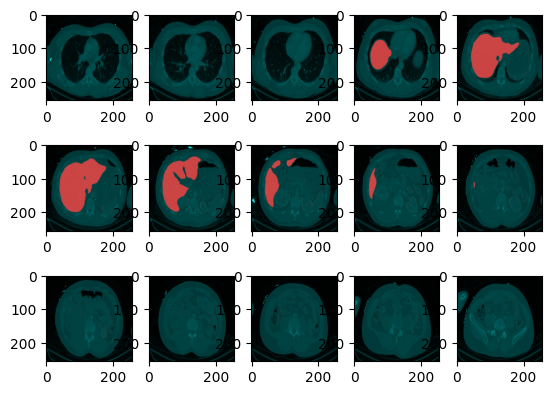

In [20]:
print(len(train_dataset))

show_id = np.random.randint(0,len(train_dataset))
train_data = train_dataset[show_id]
show_img = train_data[1]
print(s_id_p_id[str(train_data[0])], train_data[0])
print(show_img.shape)

for ii in range(15):
    show_slice = int(show_img.shape[0]/15*ii)
    show_mask = show_img[show_slice][1]
    show_jpg = show_img[show_slice][0]
    plt.subplot(3,5,ii+1);plt.imshow(np.stack([show_mask,show_jpg,show_jpg],axis=2).astype(np.int32))

In [21]:
from tqdm import tqdm

In [22]:
torch.cuda.empty_cache()

In [23]:
print(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{0}_fold{0}_{3}labels_{version}.pth')
os.path.exists(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{0}_fold{0}_{3}labels_{version}.pth')

./models/resnet18LSTM/resnet18_liver_128_256_256_ep0_fold0_3labels_1008.pth


False

In [25]:
from sklearn.model_selection import KFold, GroupKFold

gkf = KFold(n_splits=4)
for i, (train_index, val_index) in enumerate(gkf.split(train_df, groups=train_df["patient_id"])):
    train_df.loc[val_index,"fold"]=i
trn_df = train_df[train_df.fold!=0].reset_index(drop=True)
# trn_df = train_df
val_df = train_df[train_df.fold==0].reset_index(drop=True)
for col in TARGET_COLS:
    print(col, np.sum(trn_df[col].values),len(trn_df),np.sum(val_df[col].values),len(val_df))


liver_healthy 3136 3485 1039 1162
liver_low 287 3485 94 1162
liver_high 62 3485 29 1162


In [26]:
neg_trn_df = pd.concat([trn_df[trn_df[TARGET_COLS[1]]==1],trn_df[trn_df[TARGET_COLS[2]]==1]],axis=0)
print("negative",len(neg_trn_df),TARGET_COLS[1],np.sum(neg_trn_df[TARGET_COLS[1]]),TARGET_COLS[2], np.sum(neg_trn_df[TARGET_COLS[2]]))
pos_trn_df = trn_df[~trn_df.series_id.isin(neg_trn_df.series_id.values)]
pos_trn_df = pos_trn_df.iloc[np.random.choice(len(pos_trn_df),len(neg_trn_df))]
print("positive", len(pos_trn_df),np.sum(pos_trn_df[TARGET_COLS[1]])+np.sum(pos_trn_df[TARGET_COLS[2]]))

trn_df = pd.concat([neg_trn_df,pos_trn_df],axis=0).reset_index(drop=True)
for col in TARGET_COLS:
    print(col, np.sum(trn_df[col].values),len(trn_df),np.sum(val_df[col].values),len(val_df))


negative 349 liver_low 287 liver_high 62
positive 349 0
liver_healthy 349 698 1039 1162
liver_low 287 698 94 1162
liver_high 62 698 29 1162


In [40]:
from datetime import datetime
train_loader = torch.utils.data.DataLoader(TrainDataset(trn_df), batch_size=1, shuffle=True, num_workers=0, drop_last=True)
valid_loader = torch.utils.data.DataLoader(TrainDataset(val_df), batch_size=4, shuffle=True, num_workers=0, drop_last=True)

def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (sid, input, target) in enumerate(train_loader):
        if i %100 == 0 and i !=0:
            print(datetime.now(), f"epoch{epoch}",i, len(train_loader), train_loss / i)
            print(input.shape, target.shape)
            fw = open(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_{len(TARGET_COLS)}labels_{version}.txt','a')
            fw.write(" ".join([str(x) for x in ["train", f"epoch{epoch}", datetime.now(), \
                    i, len(train_loader), train_loss / i,input.shape, target.shape]])+"\n")
            fw.close()
        input = input.cuda()
        target = target.cuda()
        print(input.shape)
        # compute output

        output = model(input)
        print(input.shape,target.shape,output.shape)
        # print(output.shape, target.shape)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
        torch.cuda.empty_cache()
    return train_loss/len(train_loader)

def validate(val_loader, model, criterion):
    model.eval()
    val_loss = 0.0
    
    val_pred = []
    val_label = []
    with torch.no_grad():
        for i, (sid, input, target) in enumerate(val_loader):
            if i %50 == 0 and i !=0:
                print(datetime.now(), i, len(val_loader), val_loss / i)
                print(input.shape)
                fw = open(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_{len(TARGET_COLS)}labels_{version}.txt','a')
                fw.write(" ".join([str(x) for x in ["valid", f"epoch{epoch}", datetime.now(), \
                        i, len(val_loader), val_loss / i,input.shape, target.shape]])+"\n")
                fw.close()
            input = input.cuda()
            target = target.cuda()
            output = model(input)
            val_loss += criterion(output, target)
            
            output = torch.sigmoid(output)
            val_pred.append(output.data.cpu().numpy())
            val_label.append(target.data.cpu().numpy())
    return val_loss / len(val_loader.dataset), val_pred, val_label

pos_weights = {"lkidney":[1,4,8],"rkidney":[1,2],"kidney":[1,2,4],"bowel":[1,4,1,4],\
               "liver":[1,2,4],"spleen":[1,4,8],"all":[1,2,1,6,1,2,4,1,2,4,1,2,4,6]}

pos_weight = torch.Tensor([1,2,1,6,1,2,4,1,2,4,1,2,4]).cuda()
pos_weight = torch.Tensor(pos_weights[organ_name]).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)#pos_weight=pos_weight)
optimizer = torch.optim.SGD(model.parameters(), 0.00015)
# model.load_state_dict(torch.load(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{0}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth'))
if not os.path.exists(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_{len(TARGET_COLS)}labels_{version}.txt'):
    fw = open(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_{len(TARGET_COLS)}labels_{version}.txt','w')

for epoch in range(1,5):
    train_loss = train(train_loader, model, criterion, optimizer)
    torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_loss{"_".join([str(xx) for xx in pos_weights[organ_name]])}_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')
    val_loss = validate(valid_loader, model, criterion)
    

liver_healthy 2692 3000 890 1001
liver_low 251 3000 83 1001
liver_high 57 3000 28 1001
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256]) torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 128, 2, 256, 256])
torch.Size([1, 128, 2, 256, 256

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_128_256_256_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
fw.close()

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_ep{2}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
pd.read_csv('submission.csv')